### Banknote authentication

In this script I will evaluate different predictors for a banknote authentcation system.

The data is taken from the <a href="https://archive.ics.uci.edu/ml/datasets/banknote+authentication">UCI Machine Learning Repository</a> and it contains different features extracted from images that were taken for the evaluation of an authentication procedure for banknotes.

##### Information about the dataset:
It contains four features and the class.
 <ol>
  <li>Variance of Wavelet Transformed image (vwti) - continuous</li>
  <li>Skewness of Wavelet Transformed image (swti) - continuous</li>
  <li>Curtosis of Wavelet Transformed image (cwti) - continuous</li>
  <li>Entropy of image (eoi) - continuous</li>
  <li>Class - banknote is authenticated (1) ot not (0) - integer</li>
</ol> 

I will first read the data and remove the columns with missing values if this is needed. In the next step I will visually inspect the data to see if there are dangerous outliers that have to be removed and also to see which features to use for the classification part. In the final part I will evaluate multiple classifiers.

In [2]:
% matplotlib inline

In [3]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cross_validation import train_test_split
from pandas.tools.plotting import scatter_matrix
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

In [4]:
# hide python warnings

import warnings
warnings.filterwarnings('ignore')

### 1. Reading the data and removing missing values 

In [5]:
# download and read the data

header = ["vwti", "swti", "cwti", "eoi", "cls"]
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
data = pd.read_csv(url, names=header)

In [6]:
# split data into train 80% and test 20%
train, test = train_test_split(data, test_size = 0.2)

In [7]:
# a few columns of the dataset
train.head()

,vwti,swti,cwti,eoi,cls
726,0.040498,8.52340,1.4461,-3.93060,0
970,-2.329900,-9.95320,8.4756,-1.87330,1
471,0.395590,6.88660,1.0588,-0.67587,0
870,-1.942300,0.37660,-1.2898,-0.82458,1
1188,-3.020100,-0.67253,2.7056,0.85774,1


In [8]:
train.describe()

,vwti,swti,cwti,eoi,cls
count,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000
mean,0.433787,1.989581,1.355283,-1.186164,0.443026
std,2.806766,5.812941,4.242754,2.110082,0.496970
min,-7.042100,-13.773100,-5.286100,-7.871900,0.000000
25%,-1.754900,-1.440200,-1.544300,-2.378900,0.000000
50%,0.487970,2.294800,0.616630,-0.582770,0.000000
75%,2.774400,6.836900,3.114300,0.399980,1.000000
max,6.824800,12.951600,17.927400,2.162500,1.000000


There are no missing values in the dataset.

In [9]:
# check the number of features for each class in the training set
pd.value_counts(train['cls'], sort=True)

0    611
1    486
Name: cls, dtype: int64

We have an almost equal split of the classes in the training set which is ok for the prediction task.

### 2. Visual data exploration

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000008B4BBE0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000000008BBCA90>], dtype=object)

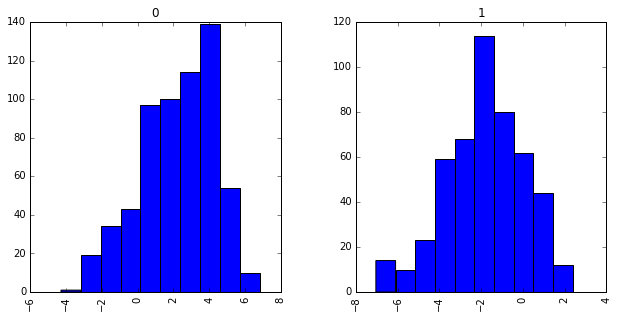

In [10]:
train.hist(column='vwti', by='cls', figsize=(10,5))

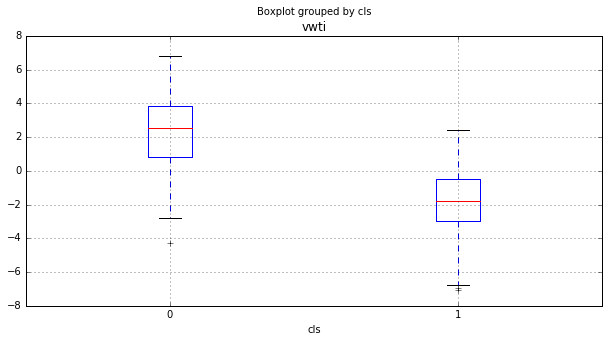

In [11]:
train.boxplot(column='vwti', by='cls', figsize=(10,5))

The vwti feature has a good variability and the mean and the meadian are quite different for the two classes. This is a good feature for classification.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000093EA160>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000943EA58>], dtype=object)

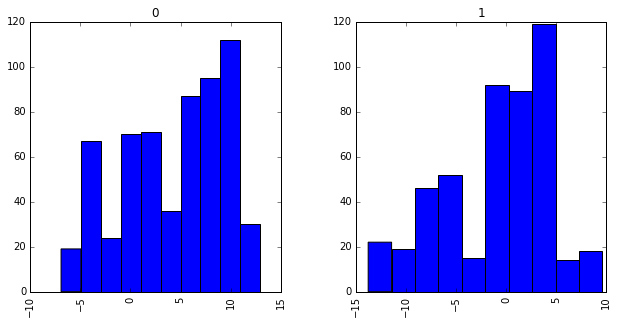

In [12]:
train.hist(column='swti', by='cls', figsize=(10,5))

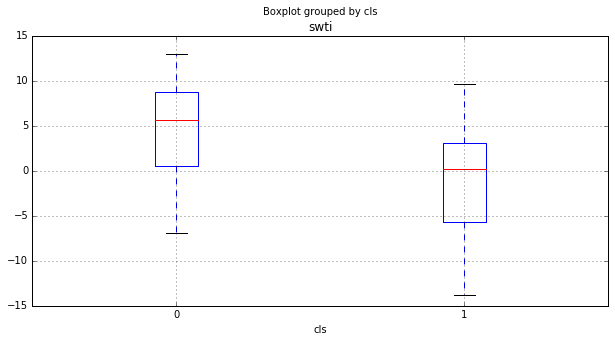

In [13]:
train.boxplot(column='swti', by='cls', figsize=(10,5))

Same for the swti feature.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000094ADF98>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000A78FDD8>], dtype=object)

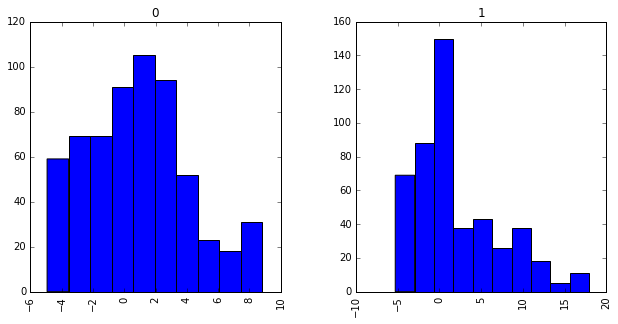

In [14]:
train.hist(column='cwti', by='cls', figsize=(10,5))

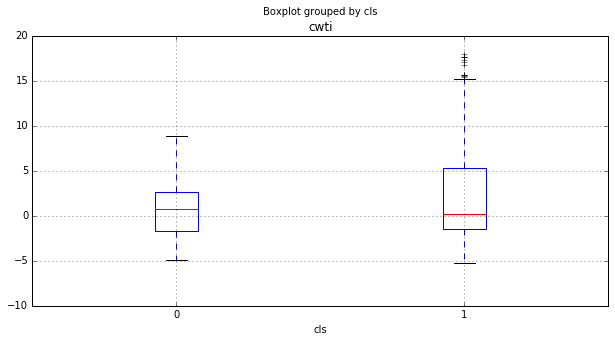

In [15]:
train.boxplot(column='cwti', by='cls', figsize=(10,5))

The cwti variable has a good variablity so it's also a good predictor.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A998390>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000A8D59E8>], dtype=object)

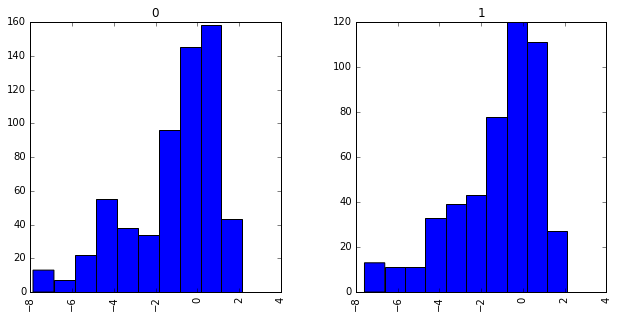

In [16]:
train.hist(column='eoi', by='cls', figsize=(10,5))

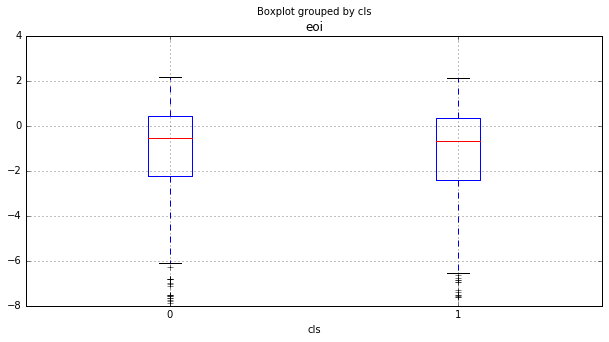

In [17]:
train.boxplot(column='eoi', by='cls', figsize=(10,5))

The eoi feature has no differences between then two classes. It has the same mean and median, the same variance and the same distribution. In will not be taken into account for the classification task.

In [18]:
# check the correlation between the features and the label
train.corr()

,vwti,swti,cwti,eoi,cls
vwti,1.000000,0.250618,-0.365813,0.273184,-0.716075
swti,0.250618,1.000000,-0.775451,-0.532269,-0.443421
cwti,-0.365813,-0.775451,1.000000,0.322376,0.132679
eoi,0.273184,-0.532269,0.322376,1.000000,-0.013334
cls,-0.716075,-0.443421,0.132679,-0.013334,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A960400>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000C4E3F28>]], dtype=object)

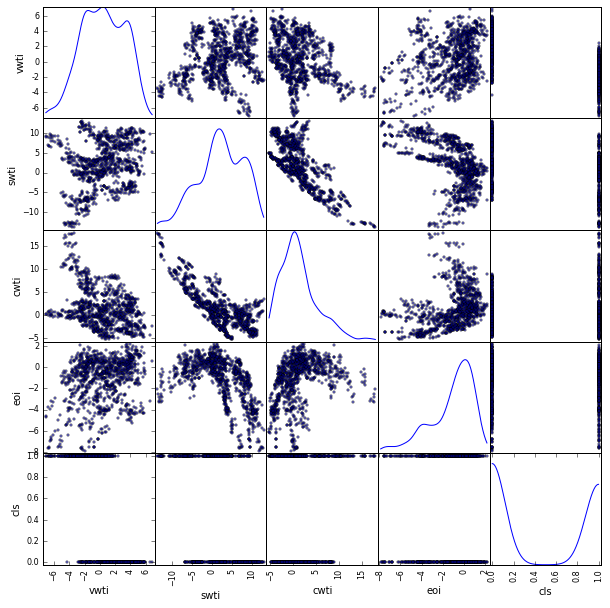

In [21]:
scatter_matrix(train, figsize=(10, 10), diagonal='kde')

From the correlation graph and matrix we can see that eoi can be removed because it's almost independent from the class.

### 3. Model selection

The model selection phase will contain three steps. First using cross-validation I will select the best parameters for a mode and I will train it. Further I will analyze how the classifier behaves with more data using a learning curve. This is useful in the context of big data. And finally I will evaluate the model with independent data. Three models will be anayled: LogisticRegression, RandomForests and NaiveBayes

In [22]:
# select only the feature names from the header
features_columns = header[:3]

In [23]:
# function taken from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [24]:
# prepare the train and test data
train = train.drop("eoi", 1)
x_train = train[features_columns].values
y_train = train.cls.values

test = test.drop("eoi", 1)
x_test = test[features_columns].values
y_test = test.cls.values

In [25]:
cv = KFold(len(x_train), n_folds=5, shuffle=True)

In [26]:
# first classifier evaluated is LogisticRegression
logReg = LogisticRegression(penalty='l2')

params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
classifier = GridSearchCV(estimator=logReg, cv=cv, param_grid=params)
classifier.fit(x_train, y_train)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=1097, n_folds=5, shuffle=True, random_state=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

<module 'matplotlib.pyplot' from 'D:\\Programming\\anaconda3\\envs\\py35\\lib\\site-packages\\matplotlib\\pyplot.py'>

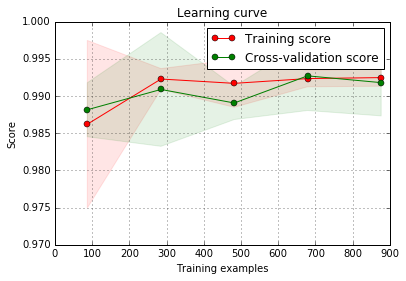

In [27]:
bestLogRegModel = LogisticRegression(penalty='l2',C=classifier.best_estimator_.C)
plot_learning_curve(bestLogRegModel, "Learning curve", x_train, y_train, cv=cv)

In [28]:
def evalClassifier(clsf):
    print(clsf.score(x_test, y_test))

    y_pred = clsf.predict(x_test)
    print(confusion_matrix(y_test, y_pred))

In [29]:
evalClassifier(classifier)

0.981818181818
[[148   3]
 [  2 122]]


In [35]:
# Then we evaluate a RandomForest ensamble
forest = RandomForestClassifier()

params = {'n_estimators': [10, 50, 100, 200, 500], 'criterion': ['gini', 'entropy']}
classifier = GridSearchCV(estimator=forest, cv=cv, param_grid=params)
classifier.fit(x_train, y_train)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=1097, n_folds=5, shuffle=True, random_state=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100, 200, 500], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

<module 'matplotlib.pyplot' from 'D:\\Programming\\anaconda3\\envs\\py35\\lib\\site-packages\\matplotlib\\pyplot.py'>

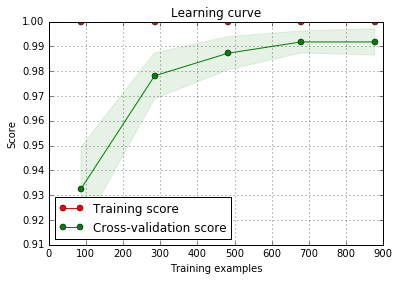

In [31]:
bestRandForestModel = RandomForestClassifier \
    (n_estimators=classifier.best_estimator_.n_estimators, \
     criterion=classifier.best_estimator_.criterion)
plot_learning_curve(bestRandForestModel, "Learning curve", x_train, y_train, cv=cv)

In [32]:
evalClassifier(classifier)

0.996363636364
[[151   0]
 [  1 123]]


<module 'matplotlib.pyplot' from 'D:\\Programming\\anaconda3\\envs\\py35\\lib\\site-packages\\matplotlib\\pyplot.py'>

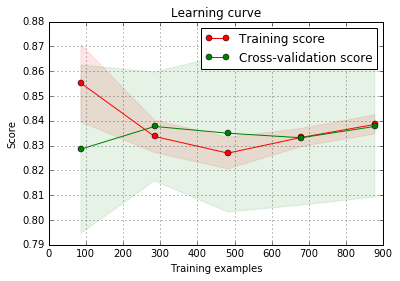

In [33]:
# And finally a naive bayes classifier
nb = GaussianNB()
nb.fit(x_train, y_train)

plot_learning_curve(nb, "Learning curve", x_train, y_train, cv=cv)

In [34]:
evalClassifier(nb)

0.872727272727
[[136  15]
 [ 20 104]]


After analyzing the models I've decided to implement further in scala LogisticRegresion and RandomeForest.